In [8]:
%matplotlib inline
import theano.tensor as tt
import numpy as np
from numpy.random import multivariate_normal

import pymc3 as pm

In [2]:
# Generate some multivariate normal data:
n_obs = 1000

# Mean values:
mu = np.linspace(0, 2, num=4)
n_var = len(mu)

# Standard deviations:
stds = np.ones(4) / 2.0

# Correlation matrix of 4 variables:
corr = np.array([[1.,  0.75,  0.,  0.15],
                 [0.75,  1., -0.06,  0.19],
                 [0., -0.06,  1., -0.04],
                 [0.15,  0.19, -0.04,  1.]])
cov_matrix = np.diag(stds).dot(corr.dot(np.diag(stds)))

dataset = multivariate_normal(mu, cov_matrix, size=n_obs)


In [3]:
# In order to convert the upper triangular correlation values to a complete
# correlation matrix, we need to construct an index matrix:
n_elem = int(n_var * (n_var - 1) / 2)
tri_index = np.zeros([n_var, n_var], dtype=int)
tri_index[np.triu_indices(n_var, k=1)] = np.arange(n_elem)
tri_index[np.triu_indices(n_var, k=1)[::-1]] = np.arange(n_elem)

with pm.Model() as model:

    mu = pm.Normal('mu', mu=0, sd=1, shape=n_var)

    # We can specify separate priors for sigma and the correlation matrix:
    sigma = pm.Uniform('sigma', shape=n_var)
    corr_triangle = pm.LKJCorr('corr', n=1, p=n_var)
    corr_matrix = corr_triangle[tri_index]
    corr_matrix = tt.fill_diagonal(corr_matrix, 1)

    cov_matrix = tt.diag(sigma).dot(corr_matrix.dot(tt.diag(sigma)))

    like = pm.MvNormal('likelihood', mu=mu, cov=cov_matrix, observed=dataset)


In [5]:
def run(n=1000):
    if n == "short":
        n = 50
    with model:
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace = pm.sample(n, step=step, start=start)
    return trace

mytrace = run()

Optimization terminated successfully.
         Current function value: 2429.413060
         Iterations: 51
         Function evaluations: 72
         Gradient evaluations: 69


100%|██████████| 1000/1000 [00:40<00:00, 24.92it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f168dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120112f98>]], dtype=object)

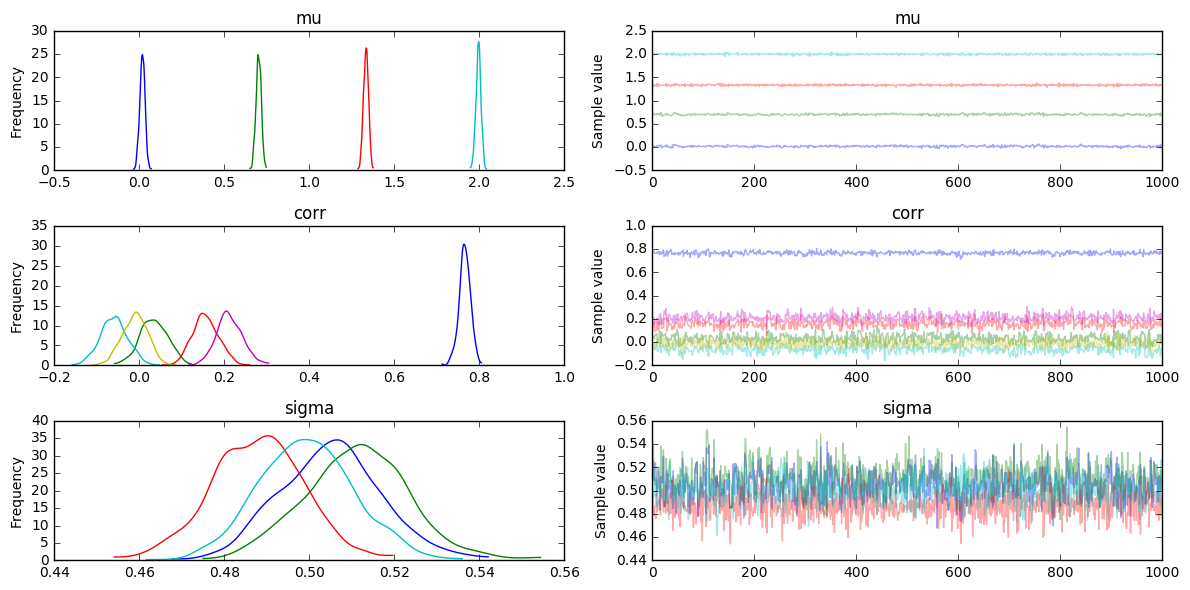

In [9]:
pm.traceplot(mytrace)

In [7]:
pm.summary(mytrace)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.018            0.016            0.001            [-0.017, 0.044]
  0.702            0.015            0.001            [0.671, 0.730]
  1.333            0.015            0.000            [1.305, 1.362]
  1.995            0.015            0.000            [1.966, 2.024]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.013         0.008          0.018          0.029          0.049
  0.672          0.693          0.702          0.713          0.732
  1.304          1.323          1.333          1.343          1.361
  1.963          1.985          1.995          2.004          2.023


corr:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------